
 - Created by:   __Andy Carter, PE__
 >andy.carter@utexas.edu

 - Created On:   __22 May 2020__<br><br>
 - Last revised:  __Verison 2.0  // Released 28 Sept 2020__<br><br>
 
 - Purpose:
 >This routine utilizes an input polygon shape of a requested area and intersects it with the TNRIS LiDAR index and the Quarter Quad index. From the intersection of these three datasets, the routine makes requests to TNRIS to download, unzip and store the necessary tiles.  Once stored, these files are merged into a single DEM and written with the appropriate metadata.
 
 - Inputs required:
  > 1) ESRI Shapefile of the TNRIS QuarterQuad shapefile (EPSG: 4269)<br>
    2) ESRI Shapefile of the TNRIS LiDAR Tile index (EPSG: 4269)<br>
    3) ESRI Shapefile of the area to be sampled (EPSG: zone does not matter)<br>
    
 - Output generated:
  > Single GeoTIFF DEM
    

***
### 1.0 References

Geopandas is used to perform the geoprocessing of the shapefiles.  This uses GDAL and Fiona.
Rasterio is used for reading, plotting and merging the raster images<br>

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
import rasterio

import osr
import gdal

import requests, zipfile, io

import os
import shutil
import glob
import matplotlib.pyplot as plt
import re

import urllib

from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.plot import show
from rasterio import features
from rasterio.warp import calculate_default_transform, reproject, Resampling

from multiprocessing.pool import ThreadPool

***
### 2.0 Input Data

This routine uses a QuarterQuad shapfile and QQQQ tile index as input.  Please set all paths prior to use.

In [2]:
# - Input
strQQ_AR = r"C:\Users\FN34GZ1\TerrainHarvest_Input\StratMap_QQ_Index_AR_4269.shp"

strLidar_AR = r"C:\Users\FN34GZ1\TerrainHarvest_Input\TNRIS_LiDAR_Available_AR_4269.shp"

strBounady_AR = r"C:\Junk\Walnut_Terrain\Walnut_AOI_AR_2277.shp"

#------------------------------------------
#Input
#2277 - Centeral Texas State Plane - UsFt - Change as needed.
int_dst_crs = 2277
dst_crs = 'EPSG:' + str(int_dst_crs)

#Input - distance of buffer on clip boundary
flt_bufferDist = 400
#------------------------------------------

# - Output
strOutput_AR = r"C:\Junk\Test_Area\Output\clip_LiDAR_QQ_AR.shp"

# Path to store the downloaded DEM zip file - Path to folder holding DEMs to merge
strDEMDownloadPath = r"C:\Junk\Test_Area\Output"

# Output path where the merged GeoTIFF will be placed
strOutTiffPath = strDEMDownloadPath + r"\dem_merge_test.tif"

# Output path where the clipped GeoTIFF will be placed
strClip_Path = strDEMDownloadPath + r"\dem_clip_test.tif"

#------------------------------------------

***
### 3.0 Read in Shapefiles

Using geopandas, read in the shapefile and plot check data

In [3]:
# Read the shapefiles using geopandas
df_QQ = gpd.read_file(strQQ_AR)

df_LiDARTiles = gpd.read_file(strLidar_AR)

#The boundary file should be in the projection (EPSG) of the final terrain.
df_boundary = gpd.read_file(strBounady_AR)

In [4]:
# Re-project the requested data Polygon into same CRS as the dst_crs
df_boundary = df_boundary.to_crs(epsg=int_dst_crs)

#Buffer the clip boundary - better to do before data request
df_boundary['geometry'] = df_boundary.geometry.buffer(flt_bufferDist,resolution=16)

In [5]:
# Re-project the requested data Polygon into same CRS as the QQ grid
df_boundary = df_boundary.to_crs(crs=df_QQ.crs)

In [6]:
print(df_QQ.crs)
print(df_LiDARTiles.crs)
print(df_boundary.crs)

epsg:4269
epsg:4269
epsg:4269


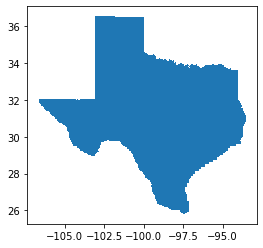

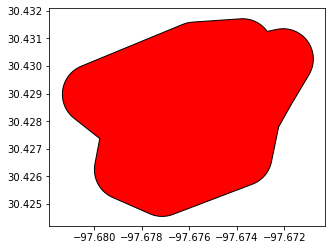

In [7]:
#Plot the TNRIS liDAR (these are the Quarter Quads)
df_QQ.plot();
#Plot the overlay polygon for the area to be querried
df_boundary.plot(color='red', edgecolor='black');

***
### 4.0 Intersect Shapefiles

Intersect the three (3) shapefiles<br>
requested limits, QuarterQuad Index, LiDAR Index

In [8]:
df_boundary.head()

,geometry
0,"POLYGON ((-97.67629 30.43153, -97.67616 30.431..."


In [9]:
# Intersection of the Quarter Quads with the requested area boundary
# To intersect, both shapefiles need to be on the same CRS
# TODO - Check and if necessary convert each of the shapefiles to the correct CRS - Web Mercator EPSG 4269
df_clip_QQ = gpd.overlay(df_QQ, df_boundary, how='intersection')

<AxesSubplot:>

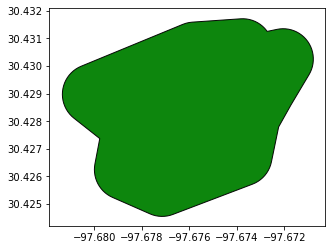

In [10]:
# Plot the intersected shapefile - These are the QuarterQuads in the boundary
#TNRIS stores the zipped DEMs as QuarterQuads
df_clip_QQ.plot(color='green', edgecolor='black', alpha=0.95)

In [11]:
#Show the attribute table for the merged shapefile for the first three records
#note that "stratmap_I" feild is the ID for the given Quarter Quad tile
df_clip_QQ.head(3)

,Quad4th,QuadName,QQuadNam,stratmap_I,geometry
0,3097_35_4,PFLUGERVILLE WEST,PFLUGERVILLE WEST SE,3097354,"POLYGON ((-97.67629 30.43153, -97.67616 30.431..."


In [12]:
# Intersection of the TNRIS LiDAR Tiles index with the watershed boundary
# This takes several seconds
df_clip_Lidar = gpd.overlay(df_LiDARTiles, df_boundary, how='intersection')

<AxesSubplot:>

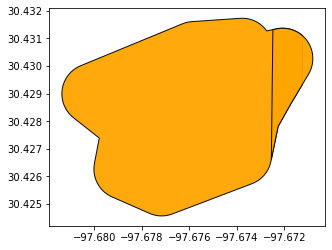

In [13]:
# Plot the intersected shapefile - These are the liDAR tiles in the boundary
df_clip_Lidar.plot(color='orange', edgecolor='black', alpha=0.95)

In [14]:
#Create a merge tile for each dataset
df_clip_Lidar.head(3)

,tilename,demname,dirname,las_size_m,dem_size_m,laz_size_m,geometry
0,stratmap17-50cm_3097354a1,stratmap17-1m_3097354a1,stratmap-2017-50cm-central-texas,573.117100,13.0,72.551294,"POLYGON ((-97.67123 30.43109, -97.67125 30.429..."
1,stratmap17-50cm_3097354a2,stratmap17-1m_3097354a2,stratmap-2017-50cm-central-texas,486.707735,13.0,54.335616,"POLYGON ((-97.67255 30.42661, -97.67249 30.431..."


In [15]:
#Intersect the QQ and the Lidar tiles
df_clip_QQ_lidar = gpd.overlay(df_clip_Lidar, df_clip_QQ, how='intersection')

<AxesSubplot:>

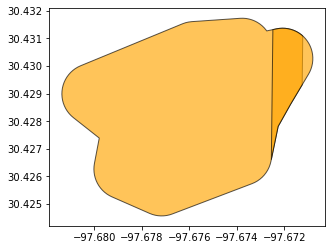

In [16]:
# Plot the intersected shapefile - These are the liDAR tiles in the boundary
df_clip_QQ_lidar.plot(color='orange', edgecolor='black', alpha=0.65)

In [17]:
#write the shapefile of the intersection of the LiDAR Tiles, requested boundary and DEM QuarterQuads
df_clip_QQ_lidar.to_file(strOutput_AR)

***
### 5.0 Determine Datasets

These are the different datasets in the requested area of interest

In [18]:
#Determine the unique 'dirname' in the df_clip_QQ_lidar
#These are the datasets that intersect the requested boundary
arr_unique_dataset = (df_clip_QQ_lidar.dirname.unique())
print(arr_unique_dataset)

['stratmap-2017-50cm-central-texas']


***
### 6.0 Functions

In [19]:
#Function - Get the TNRIS GUID for each dataset

def getTNRIS_GUID(argument):
        switcher = {
            "usgs-2018-70cm-lavaca-wharton": "642a83e0-c735-4ba6-a89c-85a723a1ad94",
            "usgs-2017-70cm-brazos-freestone-robertson": "b6ea8e3a-c8b7-4d97-b4d1-4eb8172eb87d",
            "fema-2006-140cm-coastal": "8ea19b45-7a66-4e95-9833-f9e89611d106",
            "fema-2011-61cm-comal-guadalupe": "3fbac9d5-d6ec-4201-8261-22d3d0c2684d",
            "ibwc-2006-70cm-cameron": "41bf20d7-7741-4347-ade3-915cee799e88",
            "ibwc-2011-70cm-rio-grande": "27f30e8a-115a-4ad5-ace1-5e2aa4a53a70",
            "usgs-2011-150cm-calhoun-hidalgo-nueces": "6a825941-a80b-4a61-a2b2-1da205f2f28b",
            "fema-2013-60cm-middle-brazos-palo-pinto": "2032756b-ee41-4782-bbca-59b237fe3d9e",
            "cityofgeorgetown-2015-50cm": "04f42cd7-bd81-42d2-bf9e-eca1d04e1936",
            "capcog-2008-140cm-bastrop-fayette-hays": "1f1d417a-26f2-41d5-9787-af392d0f09cf",
            "lcra-2007-140cm": "ab743202-206c-4c37-99b1-9a46db93bd4c",
            "fema-2015-70cm-middle-brazos": "2645daf3-beb7-4137-98cf-c28b97008d89",
            "hgac-2008-1m": "4e306d96-e77f-4794-b818-eba5c85140de",
            "fema-2014-1m-rio-grande": "6405ede8-8b03-411f-9544-cd6b3f6fe7fc",
            "fema-2014-70cm-upper-clear-fork": "34e6ffc2-8854-4047-9c3b-498bf10d032c",
            "fema-2016-70cm-dewitt": "4bd279fc-e358-4cdb-abc0-4e34516b21d3",
            "stratmap-2009-1m-zapata": "73fcedd4-2cfb-46af-83f0-302fae56edaa",
            "stratmap-2009-1m-mcmullen": "73fcedd4-2cfb-46af-83f0-302fae56edaa",
            "stratmap-2009-1m-goliad": "73fcedd4-2cfb-46af-83f0-302fae56edaa",
            "stratmap-2009-1m-dallas": "9aba8b42-4a55-4687-95aa-5a7cf75c970a",
            "stratmap-2009-50cm-tarrant": "7bc5f57d-f679-454f-8fd3-bdffc8d54272",
            "stratmap-2010-1m-lee-leon-madison-milam": "812c6179-28d7-4829-b99e-ae15d4a7cf5b",
            "stratmap-2010-50cm-bexar": "b133455e-0196-4e5d-b69b-a962847afce3",
            "stratmap-2010-50cm-cooke-grayson-montague-wise": "6bb27abd-b30c-4bd0-b429-a570fd999e15",
            "stratmap-2012-50cm-tceq-dam-sites": "fda08eb6-8daa-4daf-bfec-0fb0891cb732",
            "stratmap-2013-50cm-karnes-wilson": "6b475ef7-51e7-4e15-b652-4e942eafa85f",
            "stratmap-2013-50cm-ellis-henderson-hill-johnson-navarro": "6b475ef7-51e7-4e15-b652-4e942eafa85f",
            "stratmap-2014-50cm-fort-bend": "21130f88-dac2-4c36-9d9b-1fd9dc07750e",
            "stratmap-2014-50cm-bandera": "9dabb50e-00a1-46e5-8966-8a54ac424de6",
            "stratmap-2014-50cm-lampasas": "9dabb50e-00a1-46e5-8966-8a54ac424de6",
            "stratmap-2014-50cm-henderson-smith-van-zandt-trinity-river": "18c52542-dc6f-4a12-88b3-59ecc8e6d53d",
            "stratmap-2015-50cm-brazos": "48ce46cb-7aba-406c-8330-f6c5b43389c1",
            "stratmap-2017-50cm-east-texas": "f09f36b9-12b1-4c88-bccb-017afa9bc3d8",
            "stratmap-2011-1m-sabine-shelby-newton": "da097bc5-240e-400e-944f-0e403fbd781f",
            "stratmap-2011-50cm-austin-grimes-walker": "d69e74b0-9c20-4a7d-9b3d-f251eb318bfe",
            "stratmap-2011-50cm-caldwell-gonzales": "760f9068-426e-4c30-9829-177259d1da0f",
            "stratmap-2011-50cm-bell-burnet-mclennan": "02a1485c-2c6e-4f4c-9f52-17c1d59dab59",
            "stratmap-2011-50cm-collin-denton-kaufman": "d9ce5448-30a5-46cf-a246-55ba7c8304f0",
            "stratmap-2011-50cm-blanco-kendall-kerr": "760f9068-426e-4c30-9829-177259d1da0f",
            "stratmap-2017-50cm-central-texas": "0549d3ba-3f72-4710-b26c-28c65df9c70d",
            "stratmap-2017-35cm-chambers-liberty": "12342f12-2d74-44c4-9f00-a5c12ac2659c",
            "stratmap-2017-50cm-jefferson": "12342f12-2d74-44c4-9f00-a5c12ac2659c",
            "stratmap-2018-50cm-crockett": "a8ef3bfc-1e26-4fba-9abe-1b86ecd594e2",
            "usgs-2014-70cm-archer-jack": "cd8246cf-99fa-4504-b178-8c6ddecc1c02",
            "usgs-2016-70cm-middle-brazos-lake-whitney": "5a227e2c-fe2f-4e43-a981-a462c37eb488",
            "usgs-2016-70cm-neches-river-basin": "67af6a3e-2c73-446d-a5b7-243b4b6ae4ec",
            "usgs-2017-70cm-amistad-nra": "bb8bfbba-3f17-46f7-8c6b-f2785e01dd19",
            "stratmap-2018-50cm-upper-coast": "b5bd2b96-8ba5-4dc6-ba88-d88133eb6643",
            "usgs-2018-70cm-south-central": "77f928dc-298b-4b2e-9efd-8e2e16ece2c0",
            "usgs-2016-70cm-brazos-basin": "d55b62b3-fd81-4e15-a034-6fda56cde7de",
            "usgs-2017-70cm-red-river": "ff2f83a7-37e7-46a8-ba6c-d3208a51c778",
            "stratmap-2019-50cm-brown-county": "46b000dd-83b2-4701-b5c6-3f6e18cedccf",
            "stratmap-2019-50cm-missouri-city": "66d886a6-13b9-46a9-936a-bf2ce4f71aaf",
            "usgs-2018-70cm-eastern": "13563a34-6a6d-4171-ad34-fbdfb26165ae",
            "usgs-2018-70cm-south-texas": "6131ecdd-aa26-433e-9a24-97ac1afda7de",
            "usgs-2008-120cm-kenedy-kleberg": "cafa0c1b-5586-49dc-8f6a-cf1fab93362a",
            "usgs-2018-70cm-texas-panhandle": "0d805408-d173-45d1-a820-5e0d9453e972",
            "usgs-2018-70cm-texas-west-central": "de1b77e1-3110-41e7-a6a5-81cbbdda5ec3",
            "usgs-2018-70cm-lower-colorado-san-bernard": "b246f8f7-9c79-4c89-91f7-9c7f44955fca",
            "usgs-2018-50cm-matagorda-bay": "8774ed51-b633-4f03-85ca-94c311ee0a88",
        }
        return switcher.get(argument, "Nothing_Found")
    
#Function - Get the Tile Header for each dataset
# Note that the Tile header is not always equal to the dirname - UGH!

def getTNRIS_TileHeader(argument):
        switcher = {
            "usgs-2018-70cm-lavaca-wharton": "usgs18-70cm-lavaca-wharton",
            "usgs-2017-70cm-brazos-freestone-robertson": "usgs17-70cm-brazos-freestone-robertson",
            "fema-2006-140cm-coastal": "fema06-140cm-coastal",
            "fema-2011-61cm-comal-guadalupe": "fema11-61cm-comal-guadalupe",
            "ibwc-2006-70cm-cameron": "ibwc06-70cm-cameron",
            "ibwc-2011-70cm-rio-grande": "ibwc11-70cm-rio-grande",
            "usgs-2011-150cm-calhoun-hidalgo-nueces": "usgs11-150cm-calhoun-hidalgo-nueces",
            "fema-2013-60cm-middle-brazos-palo-pinto": "fema13-60cm-middle-brazos-palo-pinto",
            "cityofgeorgetown-2015-50cm": "city-of-georgetown15-50cm",
            "capcog-2008-140cm-bastrop-fayette-hays": "capcog08-140cm-bastrop-fayette-hays",
            "lcra-2007-140cm": "lcra07-140cm",
            "fema-2015-70cm-middle-brazos": "fema15-70cm-middle-brazos",
            "hgac-2008-1m": "hgac08-1m",
            "fema-2014-1m-rio-grande": "fema14-1m-rio-grande",
            "fema-2014-70cm-upper-clear-fork": "fema14-70cm-upper-clear-fork",
            "fema-2016-70cm-dewitt": "fema16-70cm-dewitt",
            "stratmap-2009-1m-zapata": "stratmap09-1m-zapata",
            "stratmap-2009-1m-mcmullen": "stratmap09-1m-mcmullen",
            "stratmap-2009-1m-goliad": "stratmap09-1m-goliad",
            "stratmap-2009-1m-dallas": "stratmap09-1m-dallas",
            "stratmap-2009-50cm-tarrant": "stratmap09-50cm-tarrant",
            "stratmap-2010-1m-lee-leon-madison-milam": "stratmap10-1m-lee-leon-madison-milam",
            "stratmap-2010-50cm-bexar": "stratmap10-50cm-bexar",
            "stratmap-2010-50cm-cooke-grayson-montague-wise": "stratmap10-50cm-cooke-grayson-montague-wise",
            "stratmap-2012-50cm-tceq-dam-sites": "stratmap12-50cm-tceq-dam-sites",
            "stratmap-2013-50cm-karnes-wilson": "stratmap13-50cm-karnes-wilson",
            "stratmap-2013-50cm-ellis-henderson-hill-johnson-navarro": "stratmap13-50cm-ellis-henderson-hill-johnson-navarro",
            "stratmap-2014-50cm-fort-bend": "stratmap14-50cm-fort-bend",
            "stratmap-2014-50cm-bandera": "stratmap14-50cm-bandera",
            "stratmap-2014-50cm-lampasas": "stratmap14-50cm-lampasas",
            "stratmap-2014-50cm-henderson-smith-van-zandt-trinity-river": "stratmap14-50cm-henderson-smith-van-zandt-trinity-river",
            "stratmap-2015-50cm-brazos": "stratmap15-50cm-brazos",
            "stratmap-2017-50cm-east-texas": "stratmap17-50cm-east-texas",
            "stratmap-2011-1m-sabine-shelby-newton": "stratmap11-1m-sabine-shelby-newton",
            "stratmap-2011-50cm-austin-grimes-walker": "stratmap11-50cm-austin-grimes-walker",
            "stratmap-2011-50cm-caldwell-gonzales": "stratmap11-50cm-caldwell-gonzales",
            "stratmap-2011-50cm-bell-burnet-mclennan": "stratmap11-50cm-bell-burnet-mclennan",
            "stratmap-2011-50cm-collin-denton-kaufman": "stratmap11-50cm-collin-denton-kaufman",
            "stratmap-2011-50cm-blanco-kendall-kerr": "stratmap11-50cm-blanco-kendall-kerr",
            "stratmap-2017-50cm-central-texas": "stratmap17-50cm-central-texas",
            "stratmap-2017-35cm-chambers-liberty": "stratmap17-35cm-chambers-liberty",
            "stratmap-2017-50cm-jefferson": "stratmap17-50cm-jefferson",
            "stratmap-2018-50cm-crockett": "stratmap18-50cm-crockett",
            "usgs-2014-70cm-archer-jack": "usgs14-70cm-archer-jack",
            "usgs-2016-70cm-middle-brazos-lake-whitney": "usgs16-70cm-middle-brazos-lake-whitney",
            "usgs-2016-70cm-neches-river-basin": "usgs16-70cm-neches-basin",
            "usgs-2017-70cm-amistad-nra": "usgs17-70cm-amistad-nra",
            "stratmap-2018-50cm-upper-coast": "stratmap18-50cm-upper-coast",
            "usgs-2018-70cm-south-central": "usgs18-70cm-south-central",
            "usgs-2016-70cm-brazos-basin": "usgs16-70cm-brazos-basin",
            "usgs-2017-70cm-red-river": "usgs17-70cm-red-river",
            "stratmap-2019-50cm-brown-county": "stratmap19-50cm-brown-county",
            "stratmap-2019-50cm-missouri-city": "stratmap19-50cm-missouri-city",
            "usgs-2018-70cm-eastern": "usgs18-70cm-eastern",
            "usgs-2018-70cm-south-texas": "usgs18-70cm-south-texas",
            "usgs-2008-120cm-kenedy-kleberg": "usgs08-120cm-kenedy-kleberg",
            "usgs-2018-70cm-texas-panhandle": "usgs18-70cm-panhandle-texas",
            "usgs-2018-70cm-texas-west-central": "usgs18-70cm-tx-west-central",
            "usgs-2018-70cm-lower-colorado-san-bernard": "usgs18-70cm-lower-colorado-san-bernard",
            "usgs-2018-50cm-matagorda-bay": "usgs18-50cm-matagorda-bay",
        }
        return switcher.get(argument, "Nothing_Found")

In [20]:
#Function - Download and unzip as DEM file from TNRIS
def funcDownloadTiles(tileURL):
    #Download each zip file and extract to the strDEMDownloadPath
    r = requests.get(tileURL)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(strDEMDownloadPath)

***
### 7.0 Build URL download list and Valid tile list

In [21]:
#For each item in the arr_unique_dataset
int_dataset = 0

#Empty list for valid tiles
arr_valid_list=[]

#Empty download url list
arr_master_url_list=[]

while int_dataset < len(arr_unique_dataset):
    #---------------------------
    #Get a geopandas table of the current dataset
    df_new = df_clip_QQ_lidar[df_clip_QQ_lidar['dirname'].isin([arr_unique_dataset[int_dataset]])]
    
    #Get a list of the unique QQ tiles for this specific dataset
    arr_unique_QQ = (df_new.stratmap_I.unique())
    
    #Unique list of DEM tiles for this specific dataset
    arr_unique_DEM_Tiles = (df_new.demname.unique())
    
    #Append the DEMs for this source to a master list
    arr_valid_list.extend(arr_unique_DEM_Tiles)
    
    #df_new.plot(color='purple', edgecolor='black', alpha=0.75)
    #---------------------------
    #Create a list of urls of the DEM tiles to download from the TNRIS server
    urls = []

    for i in arr_unique_QQ:
        # Each source have a different GUID on the AWS
        #Build a URL for the DEMs in this dataset
        strURLpath = (r"https://s3.amazonaws.com/data.tnris.org/")
        strURLpath += getTNRIS_GUID(arr_unique_dataset[int_dataset])
        strURLpath += (r"/resources/")
        strURLpath += getTNRIS_TileHeader((arr_unique_dataset[int_dataset]))
        strURLpath += (r"_") + i + "_dem.zip"
        #print(strURLpath)
        urls.append(strURLpath)
    #---------------------------
    #Due to clipping buffers and slivers there are requested tiles that do not exist
    #Remove these tiles from the urls list by making a header request

    for j in urls:
        req = urllib.request.Request(j, method='HEAD')
        try:
            r = urllib.request.urlopen(req)
        except:
            #Remove j from the url list
            #print('-----No Such File----- ' + j)
            urls.remove(j)
            pass
    #-------------------------------
    #add the valid urls to the master list
    arr_master_url_list.extend(urls)
    #-------------------------------
    int_dataset += 1

***
### 8.0 Download Tiles

In [22]:
#Download the DEM tiles per the constructed urls

print("Downloading: " + str(len(arr_master_url_list)) + " tiles")
#**************************
#Downloading the DEM tiles from the arr_master_url_list
i=0
results = ThreadPool(10).imap_unordered(funcDownloadTiles, arr_master_url_list)
for strRequestedTile in results:
    i += 1
    print(i)
print("Complete")
#**************************

#Using list comprehension to add '.img' to each item in the list
arr_valid_list = [i + '.img' for i in arr_valid_list]
#print(arr_valid_list)

#Go through the strDEMDownloadPath and remove all files that do not match an item in the arr_valid_list.
for filename in os.listdir(strDEMDownloadPath):
    if filename not in arr_valid_list:
        file_path = os.path.join(strDEMDownloadPath,filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

Downloading: 1 tiles
1
Complete


***
### 9.0 Merge DEM tiles

In [23]:
#The USGS files when downloaded and unzipped create two folders
#titled "Block_metadata" & "Projectwide_metadata"
#These files, if they exist are removed

strBlockFolder = strDEMDownloadPath + r"\Block_metadata"
strProjectwideFolder = strDEMDownloadPath + r"\Projectwide_metadata"
   
if os.path.exists(strProjectwideFolder) and os.path.isdir(strProjectwideFolder):
    shutil.rmtree(strProjectwideFolder)
    
if os.path.exists(strBlockFolder) and os.path.isdir(strBlockFolder):
    shutil.rmtree(strBlockFolder)

In [24]:
#Create the merged DEM from the downloaded files

# Create a list of all the files to merge 
# https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html

search_criteria = "*"
q = os.path.join(strDEMDownloadPath, search_criteria)
dem_files = glob.glob(q)
#dem_files[:6]

# Empty list to store opened DEM files
d = []
for file in dem_files:
    src = rasterio.open(file)
    d.append(src)
    
out_meta = src.meta.copy()

mosaic, out_trans = merge(d)

# Create Metadata of the for the mosaic TIFF
out_meta.update({"driver": "HFA","height":mosaic.shape[1],"width":mosaic.shape[2],"transform": out_trans,})

# Write the updated DEM to the specified file path
with rasterio.open(strOutTiffPath, "w", **out_meta) as dest:
    dest.write(mosaic)
    

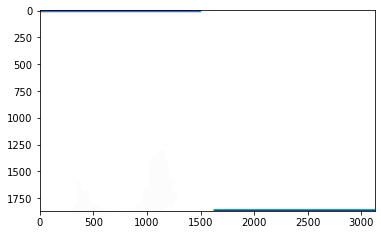

<AxesSubplot:>

In [25]:
show(mosaic, cmap='terrain')

***
### 10.0 Clip to requested limits - Convert to requested CRS

In [26]:
def getFeatures(gdf,int_polyIndex):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][int_polyIndex]['geometry']]

In [27]:
# Read the overall Terrain raster
src = rasterio.open(strOutTiffPath)

# Copy the metadata of the src terrain data
out_meta = src.meta.copy()

#Get the projection of the raster
d = gdal.Open(strOutTiffPath)
proj = osr.SpatialReference(wkt=d.GetProjection())
str_EPSG_Raster = proj.GetAttrValue('AUTHORITY',1)
print(str_EPSG_Raster)

26914


In [28]:
# re-project the clip polygon into same CRS as terrain raster
df_boundary = df_boundary.to_crs(epsg=str_EPSG_Raster)

# Converts the buffer to a GeoJson version for rasterio
# currently requests the first polygon in the geometry
coords = getFeatures(df_boundary,0)

# Clip the raster with Polygon
out_img, out_transform = mask(dataset=src, shapes=coords, crop=True)

# Metadata for the clipped image
# This uses the out_image height and width
out_meta.update({"driver": "GTiff","height":out_img.shape[1],"width":out_img.shape[2],"transform": out_transform,})

with rasterio.open(strClip_Path, "w", **out_meta) as dest:
    dest.write(out_img)

<AxesSubplot:>

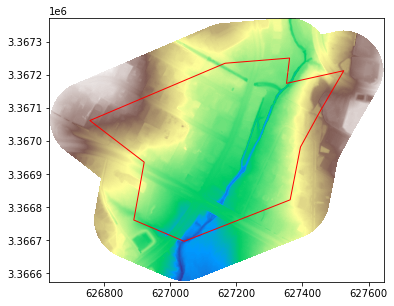

In [29]:
src2 = rasterio.open(strClip_Path)

# Re-project the requested data Polygon into same CRS as the dst_crs
df_boundary_unbuff = gpd.read_file(strBounady_AR)
df_boundary_unbuff = df_boundary_unbuff.to_crs(epsg=str_EPSG_Raster)

#print the raster and the boundary in the native raster CRS
# Plot the last terrain waterhsed on top of the clipped land use raster
fig, ax = plt.subplots(figsize=(6, 6))
show(src2, cmap='terrain', ax=ax)
df_boundary_unbuff.plot(ax=ax, facecolor='none', edgecolor='red')